<a href="https://colab.research.google.com/github/twisha-k/Python_notes/blob/main/130_coding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 130: ARIMA IV - MA and ARMA Models

---

#### Teacher-Student Activities

One of the foundational models for time series forecasting is the **Moving Average** model, denoted as **MA(q)**. It is the building block of more complex models such as the ARMA and ARIMA.

In the previous class, we explored a pure Autoregressive (AR)  model and implemented it using the `statsmodels` module. In today's class, we will explore another important component of ARIMA model i.e. Moving Average. Further, we will learn how to interpret ACF and PACF plots to determine optimal hyperparameter values.

Let us first recall the concepts covered in the previous lesson and start this lesson from **Understanding Moving Average (MA) Models**.

---

#### Recap

####  Dummy Data Preparation

Let us create a dummy dataset consisting of following two columns:              
- `Month`: Months from the year `1989` to `2000`.
- `Sales`: Random integers between `100` and `1000`.

In [ ]:
# Generate random time series data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

np.random.seed(10)  # Use 'seed()' to generate same random integers on every execution of code.

time = pd.date_range(start = '1999-01-01', end = '1999-12-31', freq='D')

prices = sorted(np.random.randint(120, 500, len(time)))

price_df = pd.DataFrame({'Days': time, 'Price': prices})
price_df.head()

,Days,Price
0,1999-01-01,120
1,1999-01-02,120
2,1999-01-03,122
3,1999-01-04,123
4,1999-01-05,123


In [ ]:
# Get the total number of rows and columns and data types of columns.
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Days    365 non-null    datetime64[ns]
 1   Price   365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


Set `Days` as index

In [ ]:
# Set 'Days' column as index of the DataFrame
price_ind_df = price_df.set_index('Days')
price_ind_df.head()

,Price
Days,
1999-01-01,120
1999-01-02,120
1999-01-03,122
1999-01-04,123
1999-01-05,123


---

#### Understanding Autoregression

Recall the simple linear regression model equation:

$$y = \beta_0 + \beta_1 x + \epsilon \tag{1.1}$$

Where,
- $x$ is independent variable or feature.

- $y$ is the target variable whose value is to be predicted.

- $\beta_0$ is the intercept or the constant.
- $\beta_1$ is the regression coefficient for feature $x$.

- **$\epsilon$** is the random error or residual obtained along with the predicted value.

If we replace $x$ with $y_{t-1}$ , $y$ with $y_{t}$ and $ \epsilon$ with $ \epsilon_{t}$ in equation 1.1, we get:

$$y_t = \beta_0 + \beta_1 y_{t-1} + \epsilon_t \tag{1.2}$$

Here,
 - $y_t$ is the value of target variable $y$ obtained at current time $t$.
 - $y_{t-1}$ is the value of target variable $y$  at a previous time lag $(t-1)$.
 - **$\epsilon_t$** is the random error or residual obtained for current time $t$.

Let us use $\phi$ instead of $\beta$ to represent coefficients.

Thus, equation 1.2 can be rewritten as:

$$y_t = \phi_0 + \phi_1 y_{t-1} + \epsilon_t \tag{1.3}$$

Thus, the target variable in the previous time period ($y_{t-1}$) has become the predictor. This is nothing but an **Autoregressive (AR)** model.

<img src="https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/2ed779bb-99bf-4856-9770-ff63fd5913f1.png" width = 25 width = 20/> An **AR** model uses a linear combination of past values of the target variable to predict its future value. Autoregression is made of the word, **Auto** and **Regression** which means  linear regression on itself (auto). Thus, it is actually training a regression model on the value of the target variable itself.

**Order of an AR model (`p`):**

The order of an AR model is the number of immediately preceding values in the series that are used to predict the value at present. So, the equation (1.3) model is a first-order autoregression, written as **AR(1)**.

Similarly, if we want to predict $y$ using two previous time lags, for example measuring global temperature in the previous two years ($y_{t-1}$, $y_{t-2}$), then the autoregressive model for doing so would be:

$$y_t = \phi_0 + \phi_1 y_{t-1} + \phi_2 y_{t-2}+ \epsilon_t \tag{1.4}$$

This model is a second-order autoregression, written as **AR(2)**, since the value at time $t$  is predicted from the values at times $t-1$ and $t-2$. This is similar to multiple linear regression model using two feature variables.

More generally, the auto-regressive model is defined as **AR(p)**, where `p` refers to the order of the AR
component:

$$\boxed{y_t = \phi_0 + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \epsilon_t } \tag{1.5}$$

---

#### Correlation and Autocorrelation

An autoregression model makes an assumption that the observations at current and previous
time steps are useful to predict the value at the next time step. This relationship between
variables is called **Correlation**.

In one of the previous classes, we already explored the concept of correlation and correlation coefficient. Let us recall these terms.

**Correlation:**

- Correlation measures the strength of a linear relationship between two variables.
- A correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.

**Autocorrelation:**
- Similar to correlation, for a time series model, we can determine the strength of linear relationship between the output variable $y_t$ and its values at previous time lags.
- *As the correlation is calculated between the
variable and itself at previous time steps, it is called an <b>Autocorrelation</b>*.
- Thus, lag-1 autocorrelation is the correlation between $y_t$ and $y_{t-1}$.
- Similarly, lag-2 autocorrelation is the correlation between $y_t$ and $y_{t-2}$ and so on.
- Similar to correlation coefficient, the autocorrelation coefficients also lies in the range of (-1, 1) including -1 and 1.

**Why to determine autocorrelation?**

The autocorrelation statistics helps to choose which lag variables will be useful in a model
and which will not. If all lag variables show low or no correlation with the output variable, then it suggests that the time series problem may not be predictable. Thus, determining autocorrelation can be very useful when getting started on a new dataset.

Let us investigate the autocorrelation of the price dummy dataset to determine whether there exists any autocorrelation. If yes, then we will develop
an AR model to make predictions. If not, then we cannot use AR model for prediction.

**1. Checking correlation using `lag_plot()` function:**

A quick check for autocorrelation would be to plot the observation at the current time step ($t$) with the observation at the previous time step   ($t-1$) as a scatter plot.

This could be done manually by first creating a
lag-1 version of the time series dataset and using a built-in scatter plot function in the Pandas
library. But there is an easier way.
Pandas provide a built-in plot to do exactly this, called the `lag plot()` function.

To use this function, import `lag_plot` from `pandas.plotting` module and pass the DataFrame as input to this function.



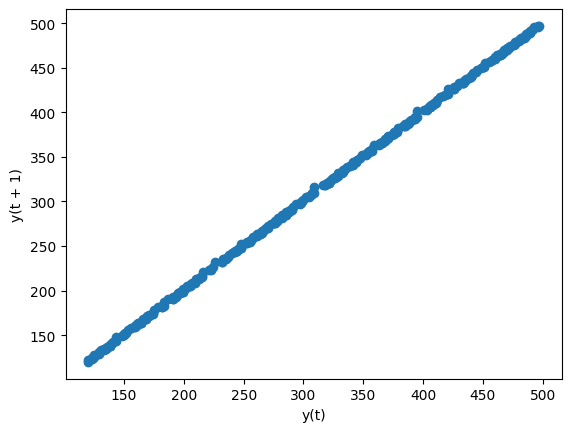

In [ ]:
# Determine lag-1 autocorrelation using 'lag_plot()' function.
from pandas.plotting import lag_plot
lag_plot(price_ind_df)
plt.show()

Running the above code plots the today's price data ($t$) on the $x$-axis against the price on the previous day ($t-1$) on the $y$-axis. We can see a large number of observations along a diagonal line of the plot. It clearly shows a relationship or correlation.

Another way to check for  autocorrelation is to directly calculate the correlation coefficient between the observation and the lag variable using the `corr()` function.

**2. Checking correlation using `corr()` function:**

We had already used `corr()` function to calculate correlation coefficient values between the numeric columns of a DataFrame.

To use this function for time-series dataset, first create a lag-1 version of the dataset and then calculate a correlation matrix between original variable and lag-1 variable. To do so, follow the steps given below:
1. Create an empty DataFrame `corr_df`.
2. Store the `'Price'` column of original indexed DataFrame as `'t'` column in `corr_df` DataFrame.
3. Shift the original DataFrame by 1 to obtain its lag-1 version using `shift(1)` function.
4. Store the lag-1 values as `'t-1'` column in `corr_df` DataFrame.
5. Use `corr()` function with `corr_df` DataFrame to print the correlation coefficient between $y_t$ and $y_{t-1}$.

In [ ]:
# Create lagged version of dataset
corr_df = pd.DataFrame()
corr_df['t'] = price_ind_df['Price']
lag1_df = price_ind_df.shift(1)
corr_df['t-1'] = lag1_df
corr_df

,t,t-1
Days,,
1999-01-01,120,NaN
1999-01-02,120,120.0
1999-01-03,122,120.0
1999-01-04,123,122.0
1999-01-05,123,123.0
...,...,...
1999-12-27,493,492.0
1999-12-28,496,493.0
1999-12-29,496,496.0


In [ ]:
# Print the lag-1 correlation coefficient
print("Lag-1 correlation coefficient:")
print(corr_df.corr())

Lag-1 correlation coefficient:
           t      t-1
t    1.00000  0.99995
t-1  0.99995  1.00000


It shows a strong positive correlation (0.99)
between the observation and the $\text{lag} = 1$ value. Similarly, we can calculate the correlation between the observation and other lag variables like $\text{lag} = 2$,  $\text{lag} = 3$ and so on. But this would be a tedious task if we want to check a large number of lag variables in our time series.

Let us study the scaled-up version of this approach.

**3. Autocorrelation Function (ACF) plots:**

We can plot the correlation coefficient for each lag variable using `plot_acf()` function. The autocorrelation function (ACF) gives us the values of autocorrelation of any series  with its lagged values.


To plot autocorrelation function, import `plot_acf()` from `statsmodels.graphics.tsaplots` module and pass the indexed DataFrame as input to this function.

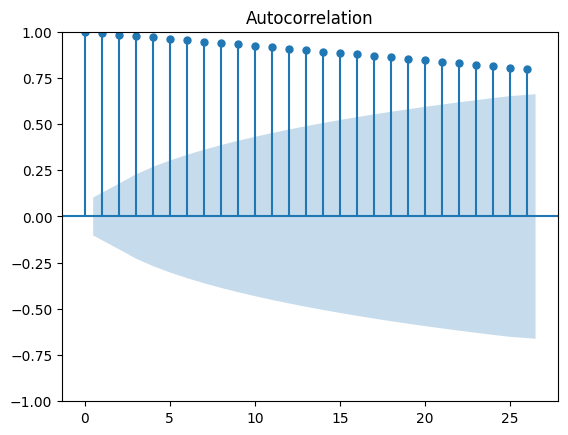

In [ ]:
# Plot ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(price_ind_df)
plt.show()

The above plot provides the lag number along the $x$-axis and the correlation coefficient value
between -1 and 1 on the y-axis.

Blue bars on an ACF plot above are the error bands, and anything within these bars is not statistically significant. It means that correlation values outside of this area are very likely a correlation and not a statistical fluke.

For our price dummy dataset, all the lag variables are statistically significant. However, this may not be the case for every AR model.

For example, if your ACF plot looks like this:

<center><img src="https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/951844a8-2c2c-446d-bcc3-7c0712f0e1f8.png"/>

`Fig 2.1: A sample ACF plot of an AR model`
</center>

In this case, only first 4 lag values are statistically significant as they are outside the error bands.


Notice that for a lag 0, ACF is always equal to one, which makes sense because the signal is always perfectly correlated with itself.

To summarise,
- Autocorrelation is the correlation between a variable and its values at previous time steps.
- ACF plots are simply a visual representation of autocorrelation.


Let us understand one more type of function which plays a major role in determining the order of an AR model (`p`).

---

#### Understanding Partial Autocorrelation

So far, we have discussed autocorrelation which is a measure of linear dependency between variables $y_t$ and  $y_{t-p}$. AR models capture this dependency as a linear regression between  $y_t$ and  $y_{t-p}$.

However, it may be possible that the autocorrelation between $y_t$ and $y_{t-p}$ is influenced by intermediate variables like $y_{t-1}, y_{t-2}, y_{t-3} ...$ and so on.  For example, the autocorrelation between $y_t$ and $y_{t-3}$ might be affected by correlations between $y_{t-1}$ and $y_{t-2}$.

Therefore, if we are using AR model, autocorrelation is not the correct measure of the actual correlation between $y_t$ and $y_{t-p}$ in the presence of the
intermediate variables.

**Partial autocorrelation** solves this problem by measuring the correlation between $y_t$ and $y_{t-p}$ when the influence of the intermediate variables has been removed. Thus, the partial autocorrelation at lag `p` is the correlation that results after removing the effect of any correlations due to the intermediate lags.

For example, lag-3 partial autocorrelation i.e partial autocorrelation of $y_t$ and $y_{t-3}$ will consist of correlation with only those parts or components of $y_{t-3}$ that were not explained by $y_{t-1}$ and $y_{t-2}$. Thus, it skips the intermediate correlations among the lags.

**Partial Autocorrelation Function (PACF):**

- PACF is the partial autocorrelation function that explains the partial correlation between the series and lags of itself.
- It is similar to the concept of ACF except that it removes the effect of previous time periods.
- Partial autocorrelation helps in identifying the order `p` of an AR(p) model.

**Why not use ACF plots to determine order `p` of an AR model?**

We cannot use the ACF plot to identify order `p` of a pure AR model as it exhibits good correlations even for the lags which are far in the past as seen in the plot below:
<center>
<img src="https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/1296483b-0a8c-4903-995b-763499694dd6.png"/>

`Fig 3.1: ACF plot of price dummy dataset`
</center>

Here, we can observe that all the lags have good autocorrelation. If we consider these many lags (for example, `p = 25`) for our AR model, then the equation for AR(25) model would look like this:

$$y_t = \phi_0 + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_{25} y_{t-25} + \epsilon_t$$

Here, $y_{t-1}, y_{t-2}, ..., y_{t-25}$ are like feature variables, similar to multiple linear regression models. These features may have high correlation among each other which result in multicollinearity problem. Let us check whether there exists multicollinearity for first 10 lagged variables by creating lagged version of the dummy dataset.

In [ ]:
# Create a dataframe having 10 lagged values of the dataset and print correlation coefficients
corr_lag_df = pd.DataFrame()
corr_lag_df['t'] = price_ind_df['Price']
for lag in range(1, 11):
  corr_lag_df['t-'+ str(lag)] =  price_ind_df.shift(lag)

print(corr_lag_df.corr())

             t       t-1       t-2       t-3       t-4       t-5       t-6  \
t     1.000000  0.999950  0.999907  0.999875  0.999844  0.999813  0.999778   
t-1   0.999950  1.000000  0.999950  0.999907  0.999874  0.999843  0.999812   
t-2   0.999907  0.999950  1.000000  0.999949  0.999906  0.999874  0.999842   
t-3   0.999875  0.999907  0.999949  1.000000  0.999949  0.999905  0.999873   
t-4   0.999844  0.999874  0.999906  0.999949  1.000000  0.999949  0.999905   
t-5   0.999813  0.999843  0.999874  0.999905  0.999949  1.000000  0.999949   
t-6   0.999778  0.999812  0.999842  0.999873  0.999905  0.999949  1.000000   
t-7   0.999735  0.999777  0.999811  0.999841  0.999872  0.999904  0.999948   
t-8   0.999693  0.999733  0.999776  0.999810  0.999841  0.999871  0.999904   
t-9   0.999655  0.999690  0.999731  0.999774  0.999809  0.999840  0.999870   
t-10  0.999619  0.999652  0.999688  0.999729  0.999773  0.999807  0.999838   

           t-7       t-8       t-9      t-10  
t     0.999735  

You may observe that all the predictors (lag-1, lag-2, .. , lag-10) have extremely high correlation coefficient amongst each other, thereby confirming the presence of multicollinearity. Hence, if we look at ACF plot and decide the order `p` of an AR model, we may end up with multicollinearity issues.



However, this is not a problem with PACF plot of AR model as it removes components already explained by earlier lags, so we only get the lags which have the correlation with the residual i.e the component not explained by earlier lags.


Let us create a PACF plot for price dummy dataset and identify the order of AR model. To do this, import `plot_pacf` function from `statsmodels.graphics.tsaplots` module and pass the indexed DataFrame as input to this function.


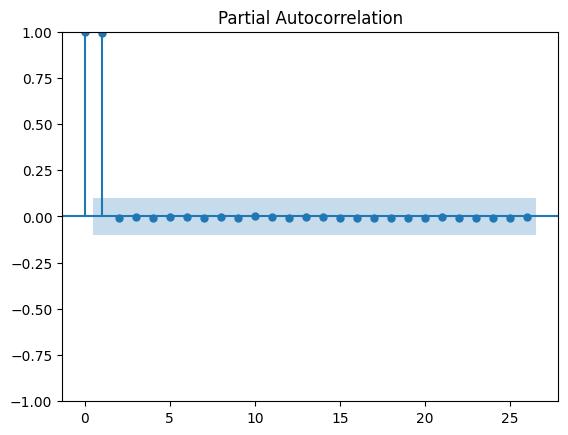

In [ ]:
# Plot PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(price_ind_df)
plt.show()

The first partial autocorrelation at lag 0 is always 1. Also note that our PACF plot has a significant spike only at lag 1, meaning that the autocorrelations for all the higher value lags like lag 2, lag 3, .. lag 25  are effectively explained by the lag-1 autocorrelation.

Hence, if we consider order of AR model to be `2` or `20` or any higher value, it would be redundant, as lag-1 is itself enough to interpret the autocorrelations for higher lag values.

Thus, the order of AR model in our case is `p = 1` i.e. we need only lag-1 variable ($y_{t-1}$).  In this way, we can determine the order of AR models using PACF plots. We will understand how to determine the order of MA and ARMA models in more detail using ACF and PACF plots in the next class.

Let us again create a line plot for our time series data.

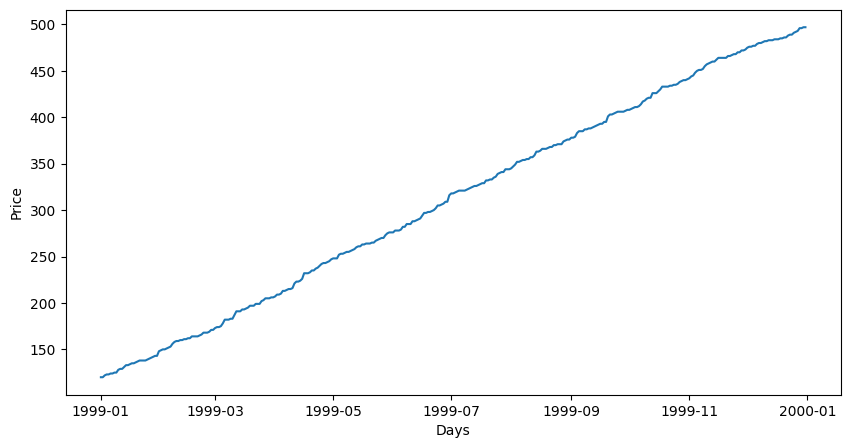

In [ ]:
# Visualise time-series plot.
plt.figure(figsize = (10, 5))
plt.xlabel('Days')
plt.ylabel('Price')
plt.plot(price_ind_df)
plt.show()

By looking at the plot, we can say that the mean and variance of the above data may or may not be constant.  Let us confirm whether the dataset is stationary or not by implementing ADF test.

In [ ]:
# Implement ADF test.
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey Fuller Test:')
adf_df = adfuller(price_ind_df['Price'])
print('ADF Statistic:', adf_df[0])
print('p-value: ', adf_df[1])

Results of Dickey Fuller Test:
ADF Statistic: -0.5879426375197536
p-value:  0.8736832875040285


You may observe that the test statistic is negative but the p-value is higher than 0.05. Thus, the null hypothesis that the data is non-stationary cannot be rejected.  Hence, we need to transform this data to make it stationary. We explored two main techniques for stationarising the time series dataset:
- Log Transformation.
- Differencing.

We will prefer differencing as ARIMA model can implicitly perform differencing in order to make time series stationary by specifying the hyperparameter `d`. This hyperparameter is nothing but the order of differencing.

Let us first manually perform differencing to determine the value of order `d`. We will start with first-order differencing.



In [ ]:
# Perform first-order differencing
first_or_diff_df = price_ind_df - price_ind_df.shift(1)  # y′t = yt − yt−1
first_or_diff_df

,Price
Days,
1999-01-01,NaN
1999-01-02,0.0
1999-01-03,2.0
1999-01-04,1.0
1999-01-05,0.0
...,...
1999-12-27,1.0
1999-12-28,3.0
1999-12-29,0.0


You can observe that the value for first observation is `NaN`. Here, the order of differencing is **`1`** as the original DataFrame is differenced only **once**.

Let us now test whether the data obtained after first order differencing is stationary or not by using ADF test. But before that, remove `NaN` values from the differenced DataFrame.

In [ ]:
# Remove NaN values and check stationarity of the time series data
first_or_diff_df.dropna(inplace = True)
print('Results of Dickey Fuller Test:')
adf_df2 = adfuller(first_or_diff_df['Price'])
print('ADF Statistic:', adf_df2[0])
print('p-value: ', adf_df2[1])

Results of Dickey Fuller Test:
ADF Statistic: -15.61130015322321
p-value:  1.7784409866599198e-28


In [ ]:
# Split the time series data into train and test sets.
train_size = int(len(price_ind_df) * 0.80)
train = price_ind_df[0:train_size]
test = price_ind_df[train_size:len(price_ind_df)]
print(train.shape)
print(test.shape)

(292, 1)
(73, 1)


In [ ]:
# Fit an ARIMA model using train set
from statsmodels.tsa.arima.model import ARIMA
model_1 = ARIMA(train, order = (1, 1, 0)) # p= 1, d = 1, q = 0
arima_train = model_1.fit()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


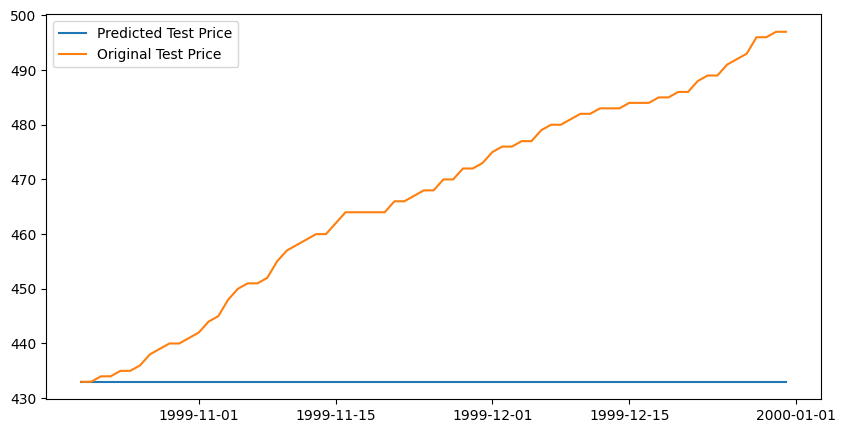

In [ ]:
# Perform prediction using 'predict()' function.
start_index = len(train)
end_index = len(price_ind_df) - 1

# Predictions against the test set
pred_test1 = arima_train.predict(start = start_index, end = end_index)

# Plot predictions and actual values
plt.figure(figsize=(10, 5))
plt.plot(pred_test1, label = 'Predicted Test Price')
plt.plot(test['Price'], label = 'Original Test Price')
plt.legend()
plt.show()


MAE: 33.84931506849315
RMSE: 38.80315620547959


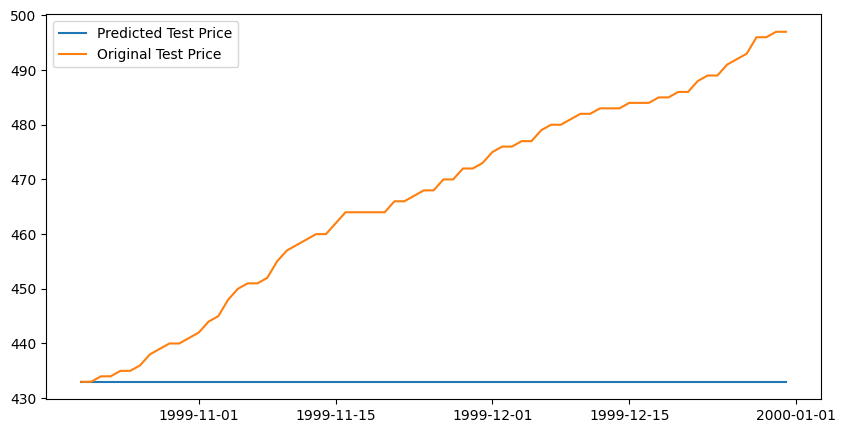

In [ ]:
# Perform prediction using 'predict()' function for original dataset.

from sklearn.metrics import mean_absolute_error, mean_squared_error
pred_test2 = arima_train.predict(start = start_index, end = end_index, typ = 'levels')

print("MAE:", mean_absolute_error(test, pred_test2))
print("RMSE:", np.sqrt(mean_squared_error(test, pred_test2)))

# Plot predictions and actual values
plt.figure(figsize = (10, 5))
plt.plot(pred_test2, label = 'Predicted Test Price')
plt.plot(test['Price'], label = 'Original Test Price')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 1.0132244458659945
RMSE: 1.3957527673769357


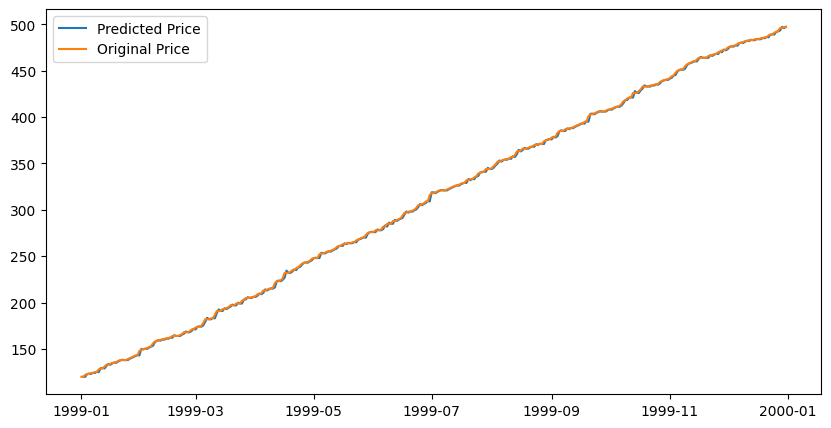

In [ ]:
# Build ARIMA model using entire dataset and plot prediction.
from statsmodels.tsa.arima.model import ARIMA
ar_model = ARIMA(price_ind_df, order = (1, 1, 0)).fit() # p= 1, d = 1, q = 0

# Predict using `predict()` function with start = 1 and end = (total observations - 1)
pred = ar_model.predict(1, len(price_ind_df) - 1, typ = 'levels' )   # start = 1, end = 364

# Print MAE and RMSE values
print("MAE:", mean_absolute_error(price_ind_df[1:], pred))
print("RMSE:", np.sqrt(mean_squared_error(price_ind_df[1:], pred)))

# Plot predictions and actual values
plt.figure(figsize=(10, 5))
plt.plot(pred, label = 'Predicted Price')
plt.plot(price_ind_df['Price'], label = 'Original Price')
plt.legend()
plt.show()

You may observe that the predictions are almost same as the actual observations for entire dataset. Also the MAE and RMSE values are very good for this model.

A quick way to plot prediction for the test set or the entire dataset would be to use `plot_predict()` function. It is similar to `predict()` function, except that it directly plots the predicted values. You can specify start and end index to specify the time period for which forecasting is to be done in the `plot_predict()` function also.

If the start and end index are not specified, then it will plot prediction for the entire dataset.

**Syntax of `plot_predict()` function:** `ARIMA.plot_predict(start, end)`

Where,

  - `start`: Zero-indexed observation number from which to start forecasting, i.e. the first forecast to start. It can also be a date string or a datetime type.
  - `end`: Zero-indexed observation number at which to end forecasting. It can also be a date string or a datetime type.


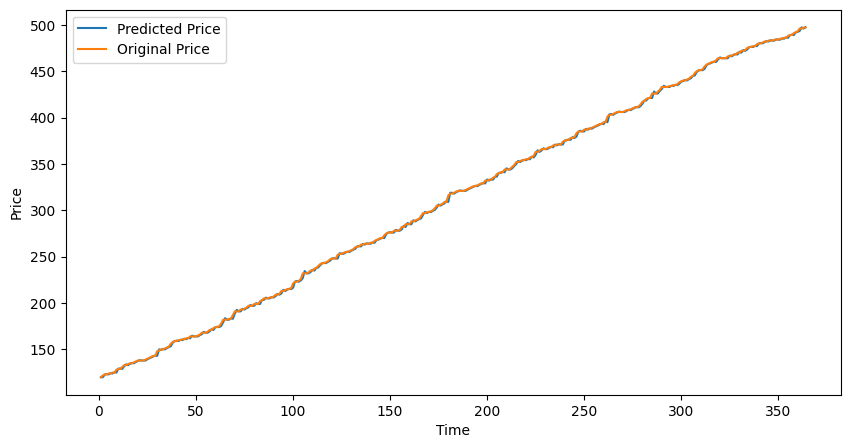

In [ ]:
# Plot predictions for entire dataset using 'plot_predict()' function.
#ar_model.plot_predict()
#plt.show()
time_index = range(1, len(price_ind_df)) # Plot predictions and actual values
plt.figure(figsize=(10, 5))
plt.plot(time_index, pred, label='Predicted Price')
plt.plot(time_index, price_ind_df['Price'][1:], label='Original Price') # Start from the second data point
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

---

#### Understanding Moving Average (MA) Models

Recall the simple AR model:
$$y_t = \phi_0 + \phi_1 y_{t-1} + \epsilon_t $$

Here, errors ($\epsilon_t$) is the residual error at time $t$.

However, just like the input observations, there may be autocorrelation or dependency between the residual errors. We may consider situations in which the error at one specific time is linearly related to the error at a previous time.  Hence, we can
create a model of the residual error time series and predict the expected error for our model.

A simple and effective model of residual error is an autoregression **Moving Average (MA)** model. This model uses past prediction errors instead of past observations to predict future values.

The simple MA model is given as:
$$y_t = \theta_0 + \theta_1 \epsilon_{t-1} + \epsilon_t \tag{1.1}$$

Where,
- $\theta_0$ is the constant or intercept (same as $\phi_0$ of AR model).
- $\theta_1$ is the regression coefficient for lag-1 error.
- $\epsilon_{t-1}$ is the residuals or error in prediction for the past period.
-  $\epsilon_{t}$ is the residuals for the current period.

Thus, MA models use dependency between residual errors to forecast values in the next time period.

The equation (1.1) is a first-order moving average **MA(1)** model as the one error term is used to predict the target variable.

Compare the AR(1) and MA(1) model equations:

<img src="https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/9abcbcf2-318f-421a-853d-db79132b9059.png"/>

The only difference in both the regression models is that the AR uses *lagged observations* whereas MA uses *lagged residual errors* to perform forecasting.

Similarly, the second-order moving average denoted by **MA(2)** is:

$$y_t = \theta_0 + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \epsilon_t \tag{4.2}$$

More generally, the MA process of order `q` is defined as:


$$y_t = \theta_0 + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots+ \theta_q \epsilon_{t-q} + \epsilon_t \tag{4.3}$$

The order `q` of the moving average model determines the number of past error terms that affect the present value.  The larger `q` means the more past error terms affect the present value. Therefore, it is important to determine the order `q` of the moving average process in order to fit the appropriate model.

We will understand how to identify the order of a MA process in the upcoming section. Before that, let us understand ARMA models.





---

####  Understanding Autoregressive Moving Average (ARMA) Models

Combining the concepts of the AR model and MA model, the ARMA model has been developed. The ARMA model combines the AR and MA models as shown below:


$$y_t = \phi_0 + \underbrace{\phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p}}_{\text{lagged values}}  + \underbrace{\theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots+ \theta_q \epsilon_{t-q} + \epsilon_t}_{\text{lagged errors}}$$

Here,
 - $p$ is the order of AR model.
 - $q$ is the order of MA model.

**The main notion of combining the concepts of the AR(p) model and the MA(q) model in the ARMA(p, q) model is to equally consider both the lagged values and lagged error values.**

By combining the concepts of both the models, the ARMA is expected to give much better results than
the individual two models. Thus, if we consider the ARMA(1,1) model, the equation can be written as:

$$y_t = \phi_0 + \phi_1 y_{t-1}  + \theta_1 \epsilon_{t-1} + \epsilon_t$$

This shows the basic calculation of the ARMA model that can be used to predict future trends.

Suppose, we want to find how much quantity of a  particular product should be manufactured by a company in this current month i.e $y_t$.
In this case, the ARMA(1,1) model will check:
- How many products were required to be manufactured in the previous month ($y_{t–1}$).
- How much error was involved in predicting the number of products required for the last month ($\epsilon_{t-1}$).
- How much error or random noise was involved in the prediction of the number for the current month ($\epsilon_{t}$).

**Autoregressive Integrated Moving Average Model (ARIMA(p,d,q)):**

When we combine differencing with ARMA model to make  time series data stationary, an ARIMA model is obtained. This model has three parameters:
- `p` is the order of AR model.
- `q` is the order of MA model.
- `d` is the order of differencing.

Thus, ARIMA(p,d,q) model is given by:

$$y'_t = \phi_0 + \underbrace{\phi_1 y'_{t-1} + \phi_2 y'_{t-2} + \dots + \phi_p y'_{t-p}}_{\text{differenced lagged values}}  + \underbrace{\theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots+ \theta_q \epsilon_{t-q}}_{\text{lagged errors}} + \epsilon_t$$

Here, $y'_t, y'_{t-1}, y'_{t-2}, \dots, y'_{t-p}$ are the differenced series terms.

Now, the main challenge is to determine the order values chosen for the ARIMA model. We already understood how to estimate order `d` value in the previous class. Let us now learn how to estimate `p` and `q` order value of AR and MA models.

---

#### Activity 1: ARIMA in Action

To understand how to estimate ARIMA model hyperparameter values, let us use a dummy dataset that contains sales of electronic gadgets of some XYZ company. The dataset contains 500 days of sales volume data starting on January 1, 2019. The volume of sales is in units of thousands of US dollars.

Let us first load the dataset and determine the number of rows and columns and their data types.

**Dataset Link:** https://s3-whjr-curriculum-uploads.whjr.online/f4cfc0d1-c1a6-4c4d-bd1c-2388821b7c90.xlsx

**Note:** This dataset is not a real world time series dataset and is solely used for learning purposes. Also, use `read_excel()` function of `pandas` module to load the dataset as it is an excel file.

**NOTE:** If the `pd.read_excel()` displays an error regarding Python version 3.x you need to uninstall the older version and fetch the updated package. For this run the following before reading the file from excel:

```
!pip uninstall openpyxl
!pip install openpyxl
```

This will update the corresponding package.

In [ ]:
# S1.1: Load the time series data and print first 5 rows.
file_path='https://s3-whjr-curriculum-uploads.whjr.online/f4cfc0d1-c1a6-4c4d-bd1c-2388821b7c90.xlsx'
gad_df=pd.read_excel(file_path)
gad_df

,Days,Sales
0,2019-01-01,50.496714
1,2019-01-02,50.805493
2,2019-01-03,51.477758
3,2019-01-04,53.542228
4,2019-01-05,54.873108
...,...,...
495,2020-05-10,64.087371
496,2020-05-11,63.992081
497,2020-05-12,63.029894
498,2020-05-13,61.671797


Get the summary of all features in the dataset.

In [ ]:
# S1.2: Get the total number of rows and columns, missing values (if any), data types of columns in the dataset.
gad_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Days    500 non-null    datetime64[ns]
 1   Sales   500 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.9 KB


There are 500 rows and 2 columns and no missing values in the dataset. Also, the data type of the `Days` column is `datetime` which is exactly what we need.  
Let us set this column as index of the DataFrame using `set_index()` function. Store this indexed DataFrame as a separate DataFrame.

In [ ]:
# S1.3: Set 'Days' column as index of the DataFrame.
gad_indf=gad_df.set_index('Days')
gad_indf

,Sales
Days,
2019-01-01,50.496714
2019-01-02,50.805493
2019-01-03,51.477758
2019-01-04,53.542228
2019-01-05,54.873108
...,...
2020-05-10,64.087371
2020-05-11,63.992081
2020-05-12,63.029894


Let us create a line plot to visualise the day-wise indexed DataFrame.

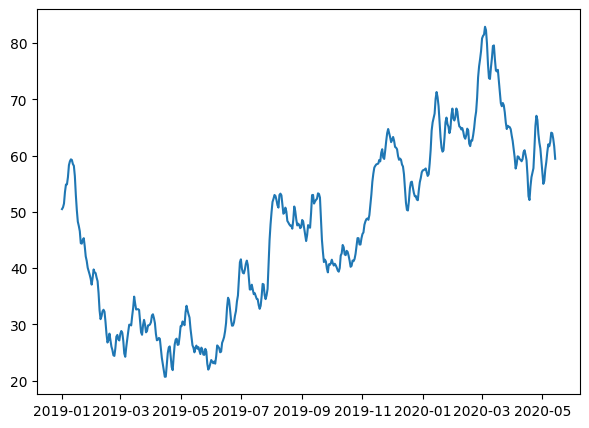

In [ ]:
# S1.4: Visualise time-series plot.
plt.figure(figsize=(7,5))
plt.plot(gad_indf)

The next step is to test for **stationarity**. From the above plot, it is clearly visible that the series is not stationary since there is an upward trend. Still, let us confirm whether the dataset is stationary or not by implementing ADF test.

In [ ]:
# S1.5: Implement ADF test.
# Import 'adfuller' from 'statsmodels.tsa.stattools'
from statsmodels.tsa.stattools import adfuller
# Get the ADF Test Results
adf_df1=adfuller(gad_indf['Sales'])
adf_df1

(-1.5121662069359065,
 0.5274845352272597,
 3,
 496,
 {'1%': -3.4436029548776395,
  '5%': -2.867384756137026,
  '10%': -2.5698830308597813},
 1354.8017397952058)

You may observe that the ADF statistic is not a large negative number and the p-value is greater than 0.05. Therefore, our time series is not stationary and we must apply transformations to make it stationary.

In order to make our series stationary, we will try to stabilise the trend by applying a first-order differencing. In the previous lessons, we implemented following formula in Python to perform first order differencing:

$$y'_t = y_t - y_{t-1}$$

Here, the previous time lag $y_{t-1}$ was calculated using `shift(1)` function.

Another way of performing first-order differencing is to use `diff(1)` function of DataFrame.

In [ ]:
# S1.6: Use 'diff(1)' function to perform first-order differencing
gad_df1=gad_indf.diff(1)
gad_df1

,Sales
Days,
2019-01-01,NaN
2019-01-02,0.308778
2019-01-03,0.672265
2019-01-04,2.064470
2019-01-05,1.330880
...,...
2020-05-10,1.651336
2020-05-11,-0.095290
2020-05-12,-0.962187


Again check whether the first-order differenced data is stationary or not by performing ADF test. Also, remove `NaN` values from the differenced dataset.

In [ ]:
# S1.7: Remove NaN values and check stationarity of the time series data
gad_df1.dropna(inplace=True)
# Drop all the NaN values
adf_df2=adfuller(gad_df1['Sales'])
adf_df2
# Get the ADF Test Results

(-10.576657780341957,
 7.076922818587346e-19,
 2,
 496,
 {'1%': -3.4436029548776395,
  '5%': -2.867384756137026,
  '10%': -2.5698830308597813},
 1350.6408606302764)

You may observe that ADF statistic is now a large negative number and the p-value is much smaller than 0.05. Hence, we can conclude that second-order differencing is not needed and our time-series is now stationary.

Next step is to estimate the hyperparameter values `p`, `d`, and `q` for implementing ARIMA model.

---

#### Activity 2: Picking Parameters for ARIMA (p,d,q)

We already know how many times we had to difference the dataset, so here the value of hyperparameter `d` is `1`.

Next, we need to figure out the values of `p` and `q`.

Remember the following rule: <img src="https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/2ed779bb-99bf-4856-9770-ff63fd5913f1.png" width = 25 width = 20/>

- To estimate order `p`, PACF plot is used.
- To estimate order `q`, ACF plot is used.

**Determining order `p`:**

In the previous lesson, we learned how to estimate order `p` using PACF plot. Let us first create a PACF plot for first-order differenced time-series.

**Note:** You may pass `lags = 10` inside `plot_pacf()` function to plot PACF only for first 10 lags, as higher order lags are anyway bad choice for `p`.

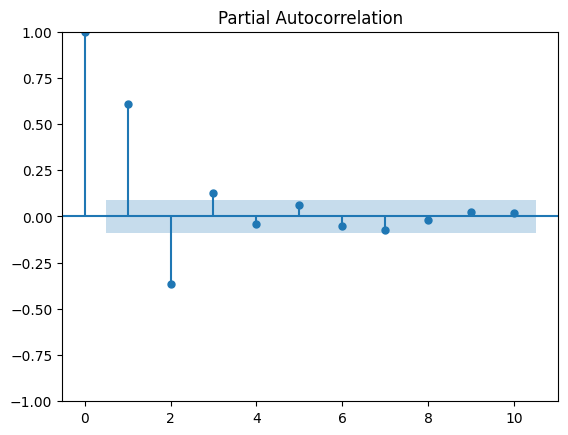

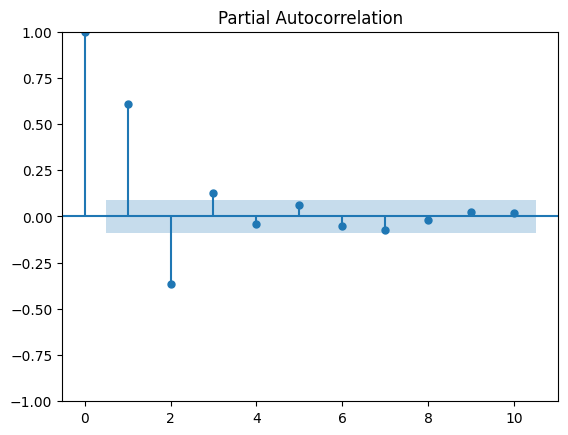

In [ ]:
# S2.1: Plot PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(gad_df1,lags=10)

The PACF at $\text{lag} = 0$ is 1, because each data point is always correlated with itself. Analysing the PACF plot,  we can see there are significant spikes at lag 1, lag 2 and lag 3. Hence, order `p` can be `1`, `2` or `3`. We will pick `p = 2`.

**Note:** You may also pick other significant `p` values and compare the model's performance for both different `p` values. However, avoid using higher `p` values to keep the model as simple as possible.

**Determining order `q`:**

Just like how we looked at the PACF plot for the number of AR terms, we will look at the ACF plot for the number of MA terms i.e value of order `q`.

Let us create an ACF plot for first-order differenced time-series.


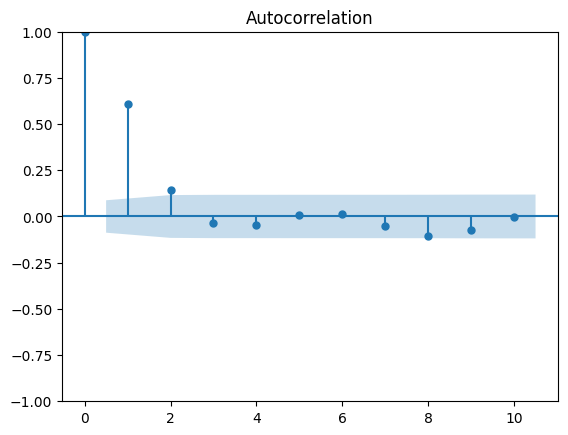

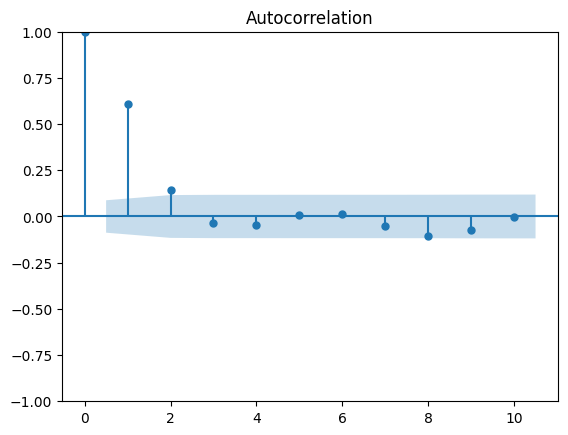

In [ ]:
# S2.2: Plot ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(gad_df1,lags=10)

Again the ACF at $\text{lag} = 0$ is 1, because each data point is always correlated with itself. Analysing the ACF plot,  we can see there are significant spikes at lag 1 and lag 2. Hence, order `q` can be `1` or `2`. We will pick `q = 2`.

Hence, the estimated values for ARIMA model are `p = 2`, `d = 1` and `q = 2 `. Note that these values may not be the best and optimal values for the hyperparamaters. We can build models using different hyperparameter values and compare the performance of these model. We will learn this in the upcoming lessons.

Estimating `p` and `q` values using ACF and PACF plots can be very tricky. Let us look at some case studies of stationary datasets and try to estimate these values for them.

---
**Case 1:**

<center>
<img src="https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/ba55c4c9-a259-41f9-b609-3a317671eb99.png"/>

`Fig 4.1: ACF and PACF plots of case 1`
</center>

Here,
- PACF drops sharply after lag 1. Hence `p = 1`.
- ACF shows a gradually decreasing trend.

Note that whenever ACF or PACF plots shows gradual decreasing trend, then the order value inferenced from that plot would be `0`.

<img src="https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/2ed779bb-99bf-4856-9770-ff63fd5913f1.png" width = 25 width = 20/> In other words,
- If PACF data points are sinusoidal* or declining gradually, then `p = 0`.

- If ACF data points are sinusoidal or declining gradually, then `q = 0`.

In the above case study, ACF plot is gradually declining, hence `q = 0`.  

**Conclusion:** `p = 1` and `q = 0` for case 1.

***Note:** A sinusoidal ACF or PACF plot may look like this:
<img src="https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/ed997e7f-7401-4b85-a1bf-4a47ba0f058a.PNG"/>

<br/>

---
<br/>

**Case 2:**

<center>
<img src="https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/1c48db1d-f740-4f2a-9b56-c2c887ff7bd9.png"/>

`Fig 4.2: ACF and PACF plots of case 2`
</center>

Here,
- PACF shows a gradual decreasing trend. Hence `p = 0`.
- ACF drops sharply after lag 1. Hence, `q = 1`.

**Conclusion:** `p = 0` and `q = 1` for case 2.

<br/>

---
<br/>

**Case 3:**

<center>
<img src="https://s3-whjr-v2-prod-bucket.whjr.online/whjr-v2-prod-bucket/f1ec52f7-4f89-4358-b467-44adb9716eb7.png"/>

`Fig 4.3: ACF and PACF plots of case 3`
</center>

Here,
- PACF shows a gradual decreasing trend. Also, it drops sharply after lag 1. Hence `p = 0` or `p = 1`. You can experiment with both the values.

- ACF drops sharply after lag 2. Hence, `q = 2`.

**Conclusion:** `p = 0` or `p = 1`, and `q = 2` for case 3.

Now that, we have understood how to estimate orders `p`, `d`, and `q` for ARIMA model, let us finally deploy the ARIMA model.


---

#### Activity 3: Deploying ARIMA Model

We are now ready to deploy ARIMA(p, d, q) model using `statsmodels` package with `p = 2`, `d = 1` and `q = 2` using the steps given below:


1. Import `ARIMA` class from `statsmodels.tsa.arima_model` module.

2. Create an object of `ARIMA` class and pass the following inputs:
  - `gadgets_in_df`:  Original indexed DataFrame.
  - `order = (2, 2, 1)`: The hyperparameter values.

3. Call the `fit()` function using the object of `ARIMA`.
4. Print the coefficient values of ARIMA model terms using `params` attribute.


In [ ]:
# S3.1: Build ARIMA model using entire dataset and plot prediction.
from statsmodels.tsa.arima.model import ARIMA
arima_1=ARIMA(gad_indf,order=(2,1,2)).fit()
arima_1.params

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ar.L1     0.643867
ar.L2    -0.204756
ma.L1     0.253661
ma.L2    -0.085442
sigma2    0.956581
dtype: float64

As our model had 2 AR and 2 MA terms, we obtained 4 coefficient values. These are nothing but the weights of the respective terms i.e.

- $\phi_0 (\text{constant}) = 0.0152$
- $\phi_1 = 0.6437$
- $\phi_2 = -0.2048$
- $\beta_1 = 0.2537$
- $\beta_2 = -0.0853$

Let us now perform prediction using `predict()` function by specifying the start and end index for differenced dataset. Also, plot the predictions

**Note:** Use `typ = 'levels'` attribute within `predict()` function to perform prediction for original observations rather than differenced observations.

Evaluate this model using accuracy metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).



0.7755192658072998


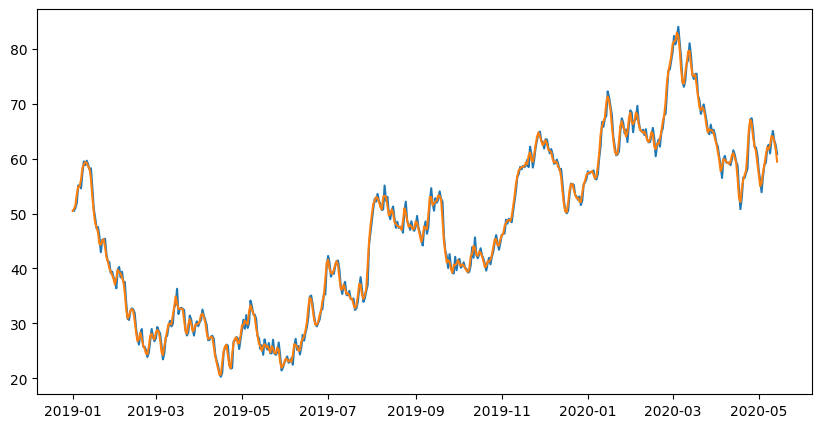

In [ ]:
# S3.2: Perform prediction using 'predict()' function for original dataset.
pred=arima_1.predict(1,len(gad_indf)-1,typ='levels')
print(mean_absolute_error(gad_indf[1:],pred))
plt.figure(figsize=(10,5))
plt.plot(pred)
plt.plot(gad_indf['Sales'])
plt.show()
# Predict using `predict()` function with start = 1 and end = (total observations - 1)


# Print MAE and RMSE values


# Plot predictions and actual values


You may observe that the predictions are very close to the actual observations. Also the MAE and RMSE values are very good for the model. Hence, ARIMA(2,1,2) worked very well for this time series data.

We will stop here. In the next class, we will deploy ARIMA model on a real world seasonal dataset and implement seasonal ARIMA.

---

### **Project**

You can now attempt the **Applied Tech Project 130** on your own.

**Applied Tech Project 130** : https://colab.research.google.com/drive/1aHUptC1HSuhXlXEB8RREVFk1wBCDwjnq

<br>

---